In [251]:
import scipy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io
from scipy import signal


In [252]:
x = (sc.io.loadmat('datasetP/P02.mat'))['data']

epochs = len(x)
# epochs = 2
electrodes = 256
measures = 201

powersDF = None

for i in range(epochs):
    epoch = pd.DataFrame(x[i])
    fourier = sc.signal.welch(epoch.loc[[7, 43, 79, 130, 184]].mean(), nperseg=measures)
    if powersDF is None:
        powersDF = pd.DataFrame(index = np.round(np.multiply(fourier[0], 100), 2))
    powersDF[i] = pd.Series(fourier[1], index = powersDF.index)


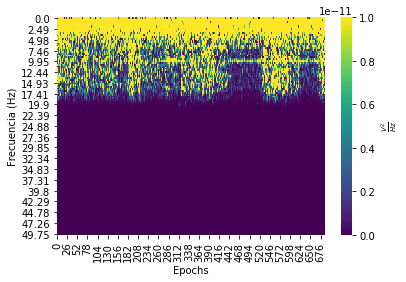

In [253]:
sns.heatmap(powersDF, cmap = 'viridis', vmin = 0, vmax = 1e-11, cbar_kws = {'label': r'$\frac{V^{2}}{Hz}$'})
plt.xlabel('Epochs')
plt.ylabel('Frecuencia (Hz)')
plt.show()


In [258]:
deltaRange = [0.0 / 100.0, 4.0 / 100.0]
thetaRange = [4.0 / 100.0, 8.0 / 100.0]
alphaRange = [8.0 / 100.0, 13.0 / 100.0]
betaRange = [13.0 / 100.0, 30.0 / 100.0]
gammaRange = [30.0 / 100.0, 50.0 / 100.0]
classification = ['P'] * 10 + ['S'] * 10
names = map((lambda x: ('0'+ str(x))[-2:]), range(1,11))
# names = ['02']
datasets = ['datasetP/P', 'datasetS/S']
# datasets = ['datasetP/P']

subjectsDelta = []
subjectsTheta = []
subjectsAlpha = []
subjectsBeta = []
subjectsGamma = []
for dataset in datasets:
    for name in names:
        x = (sc.io.loadmat(dataset + name + '.mat'))['data']
        epochs = len(x)
#         epochs = 2
        electrodes = 256
        measures = 201

        epochAcum = None
        for i in range(epochs):
            epoch = (pd.DataFrame(x[i])).sum()
            if epochAcum is None:
                epochAcum = epoch
            else:
                epochAcum = epochAcum.add(epoch)
#             fourier = sc.signal.welch(epoch, nperseg=measures)
#             plt.plot(np.round(np.multiply(fourier[0], 100), 2), fourier[1])
#         plt.show()
        
        epochAcum = epochAcum.divide(epochs * electrodes)
        fourier = sc.signal.welch(epochAcum, nperseg=measures)

        frecs = fourier[0]
        powers = fourier[1]
        theta = (i for i, v in enumerate(frecs) if v >= thetaRange[0] and v < thetaRange[1]).next()
        alpha = (i for i, v in enumerate(frecs) if v >= alphaRange[0] and v < alphaRange[1]).next()
        beta = (i for i, v in enumerate(frecs) if v >= betaRange[0] and v < betaRange[1]).next()
        gamma = (i for i, v in enumerate(frecs) if v >= gammaRange[0] and v < gammaRange[1]).next()
        subjectsDelta.append(powers[:theta].mean())
        subjectsTheta.append(powers[theta:alpha].mean())
        subjectsAlpha.append(powers[alpha:beta].mean())
        subjectsBeta.append(powers[beta:gamma].mean())
        subjectsGamma.append(powers[gamma:].mean())
        index = len(subjectsDelta)
        print 'Subject ' + names[(index - 1) % 10] + ' ' + classification[index - 1] + ': Delta', subjectsDelta[-1], 'Theta', subjectsTheta[-1], 'Alpha', subjectsAlpha[-1], 'Beta', subjectsBeta[-1], 'Gamma', subjectsGamma[-1]
#         plt.plot(np.round(np.multiply(fourier[0], 100), 2), fourier[1])
#         plt.show()


Subject 01 P: Delta 9.09547367467e-15 Theta 5.91493669091e-16 Alpha 2.24872681302e-16 Beta 5.64709781624e-17 Gamma 2.28723056068e-26
Subject 02 P: Delta 5.83647978466e-15 Theta 1.81694088561e-16 Alpha 8.20057571592e-17 Beta 1.84315423879e-17 Gamma 3.57275278293e-27
Subject 03 P: Delta 8.54126364437e-15 Theta 3.26371048692e-16 Alpha 1.6034648679e-16 Beta 2.244956194e-17 Gamma 1.17475768711e-26
Subject 04 P: Delta 8.64232504769e-16 Theta 2.06479873251e-17 Alpha 2.70380428582e-18 Beta 3.7993699119e-19 Gamma 6.76761504001e-27
Subject 05 P: Delta 3.78223650509e-14 Theta 6.21761110891e-15 Alpha 2.43559838472e-15 Beta 4.57218323503e-16 Gamma 2.90746177428e-25
Subject 06 P: Delta 2.54467727529e-16 Theta 9.17808232089e-18 Alpha 1.72362563508e-18 Beta 4.04417970443e-19 Gamma 1.54540290786e-27
Subject 07 P: Delta 1.23141627228e-14 Theta 2.31607655064e-15 Alpha 8.59494505711e-17 Beta 1.73353169042e-17 Gamma 7.33945055562e-26
Subject 08 P: Delta 3.82621202806e-14 Theta 5.5021137e-16 Alpha 5.5109236

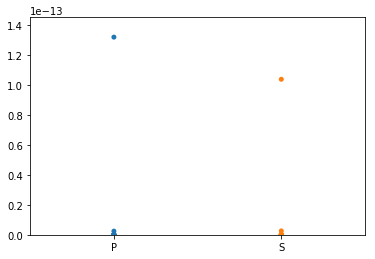

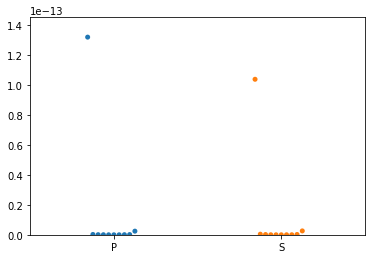

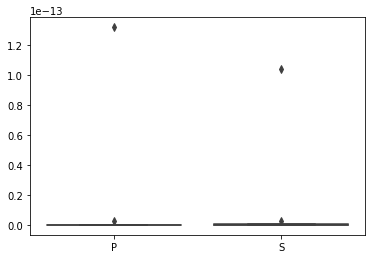

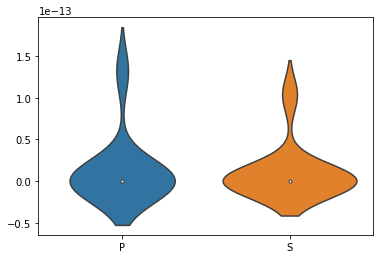

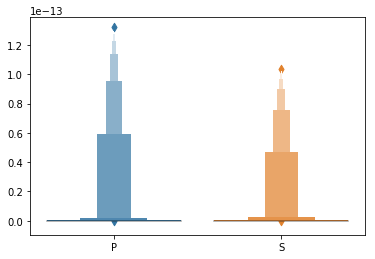

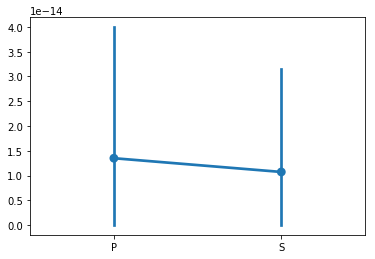

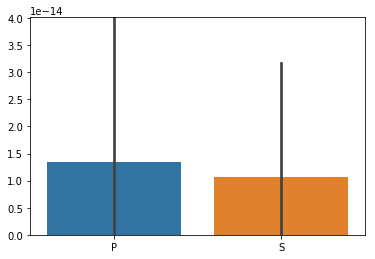

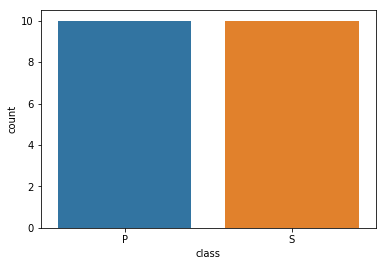

In [255]:
df = pd.DataFrame({'P': subjectsAlpha[:10], 'S': subjectsAlpha[10:]})
plots = [sns.stripplot, sns.swarmplot, sns.boxplot, sns.violinplot, sns.lvplot, sns.pointplot, sns.barplot]
for i, plotClass in enumerate(plots):
    fig = plotClass(data = df)
    if (i < 2):
        fig.set_ylim([0, df['P'].max() * 1.1])
    plt.show()

df_new = pd.DataFrame({'class': ['P'] * 10 + ['S'] * 10, 'values': subjectsAlpha})
sns.countplot(x = 'class', data = df_new)
plt.show()
